# PyMC and Universal Samplers

## Part A: `import pymc`

In [1]:
import pymc
# import pymc as pm

- [Introductory Overview of PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html)
- [Example Gallary](https://www.pymc.io/projects/examples/en/latest/gallery.html)

In [2]:
print(f"Running on PyMC v{pymc.__version__}")

Running on PyMC v5.10.4


In [3]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

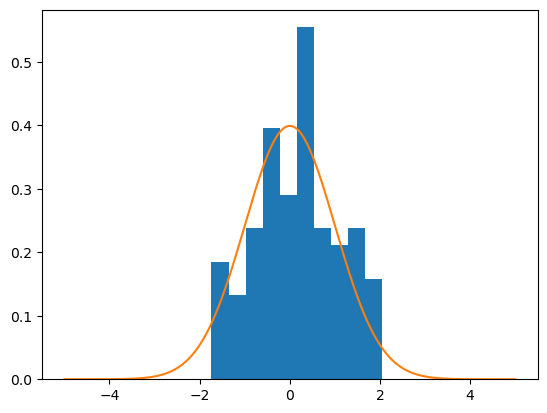

In [4]:
n = 100
true_theta, true_tau = 0,1
data_generating_mechanism = \
stats.norm(loc=true_theta, scale=true_tau**(-0.5))

x = data_generating_mechanism.rvs(size=n)
plt.hist(x, density=True)
x_grid = np.linspace(-5*true_tau**(-0.5),5*true_tau**(-0.5),1000)
plt.plot(x_grid,data_generating_mechanism.pdf(x_grid));


In [5]:
conjugate_normal_gamma = pymc.Model()

with conjugate_normal_gamma:

    # Priors for unknown model parameters
    
    theta0 = 0  # prior belief regarding true_theta
    theta_prior_n = 1  # strength of prior belief as units of data
    # theta_prior_n = tau0/true_tau
    tau0 = theta_prior_n*true_tau  
    theta = pymc.Normal("theta", mu=theta0, sigma=tau0**(-0.5))
    # Compared to scipy.stats
    # loc -> mu
    # scale -> sigma but you can also use tau as below...
    
    tau_SS_prior = 1  # prior belief regarding true_sum_of_squares
    tau_prior_n = 1  # strength of prior belief as units of data
    tau = pymc.Gamma("tau", alpha=tau_prior_n/2, 
                            beta=tau_SS_prior/2)
    # https://en.wikipedia.org/wiki/Gamma_distribution
    # pymc.Gamma?
    # Now it's **rate** (beta) NOT scale

    # Likelihood (sampling distribution) of observations
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)

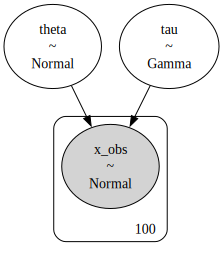

In [6]:
pymc.model_to_graphviz(conjugate_normal_gamma)

In [7]:
m = 10000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## `idata` and `arviz as az`

In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior

<xarray.Dataset> Size: 400kB
Dimensions:  (chain: 2, draw: 10000)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
Data variables:
    tau      (chain, draw) float64 160kB 1.682 1.124 1.359 ... 1.32 1.274 1.079
    theta    (chain, draw) float64 160kB 0.2347 0.1209 0.2307 ... 0.2981 0.1171
Attributes:
    created_at:                 2025-02-05T21:11:54.538883+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.10.4
    sampling_time:              5.7872633934021
    tuning_steps:               100

In [10]:
idata.posterior['theta']

<xarray.DataArray 'theta' (chain: 2, draw: 10000)> Size: 160kB
array([[0.23467862, 0.1208572 , 0.23069463, ..., 0.14379444, 0.3533305 ,
        0.21205766],
       [0.14708571, 0.13823196, 0.34260289, ..., 0.03845373, 0.29814487,
        0.11707741]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

In [11]:
idata.posterior['tau']

<xarray.DataArray 'tau' (chain: 2, draw: 10000)> Size: 160kB
array([[1.68185678, 1.12382495, 1.35865777, ..., 1.12457777, 1.11701621,
        0.88095185],
       [1.02044399, 1.08050899, 0.86525247, ..., 1.32040595, 1.27413669,
        1.07866758]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 80kB 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999

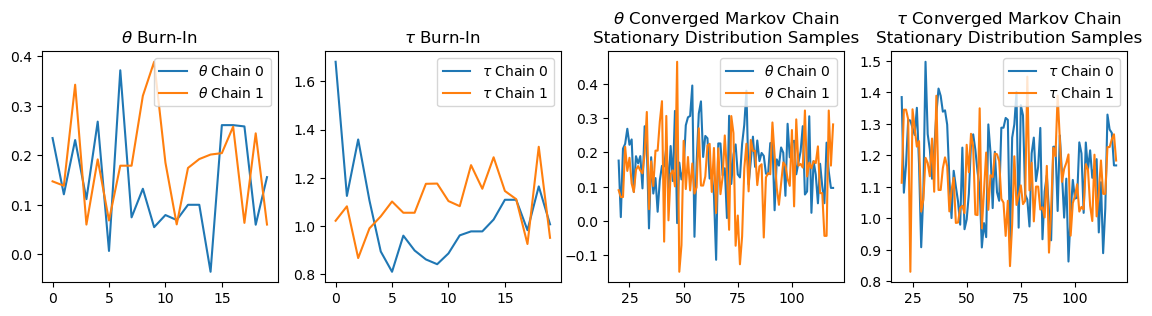

In [16]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

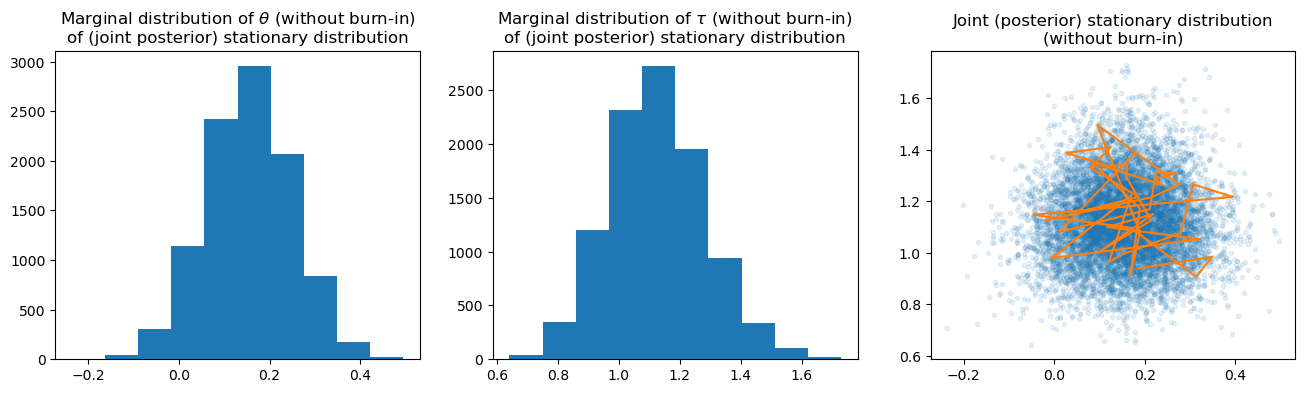

In [13]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

In [18]:
import arviz as az

In [19]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

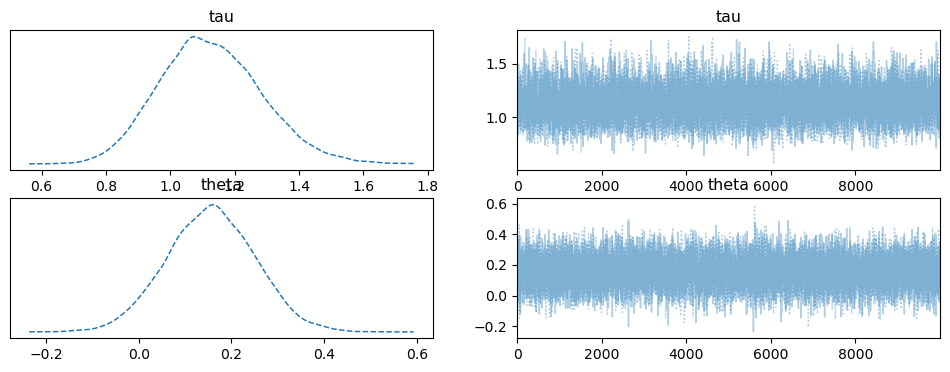

In [20]:
az.plot_trace(idata, combined=True);

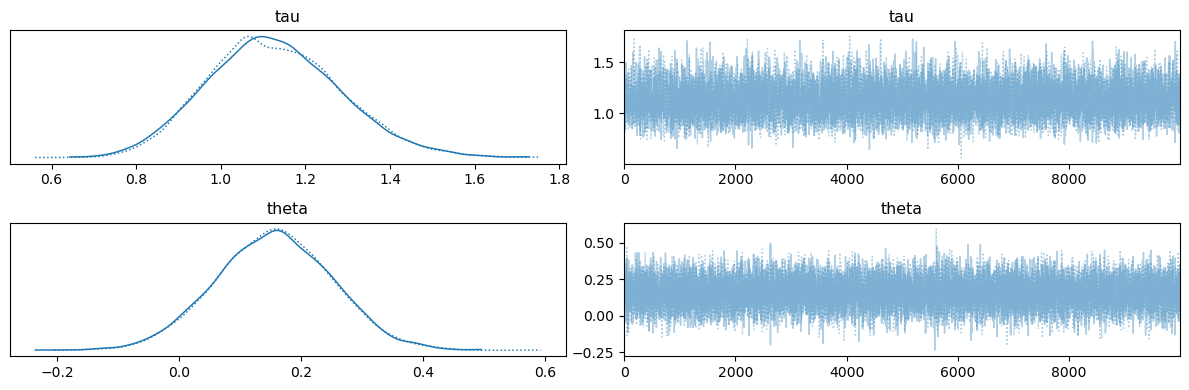

In [21]:
az.plot_trace(idata)
plt.tight_layout()

In [22]:
m = 1000
with conjugate_normal_gamma:
    # draw m posterior samples
    idata = pymc.sample(draws=m, chains=2, tune=100)
    # arviz.InferenceData object

theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 100 tune and 1_000 draw iterations (200 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [ ]:
# If the messages below don't show
"""Auto-assigning NUTS sampler...
   Initializing NUTS using jitter+adapt_diag...
   Multiprocess sampling (2 chains in 4 jobs)
   NUTS: [theta, tau] """
# You can see this information by turning on logging
import logging # dir(logging) for available functionality
_log = logging.getLogger("pymc")
#_log.setLevel(logging.NOTSET) # 0
_log.setLevel(logging.INFO) # 20
#_log.setLevel(logging.WARNING) # 30
#_log.setLevel(logging.ERROR) # 40

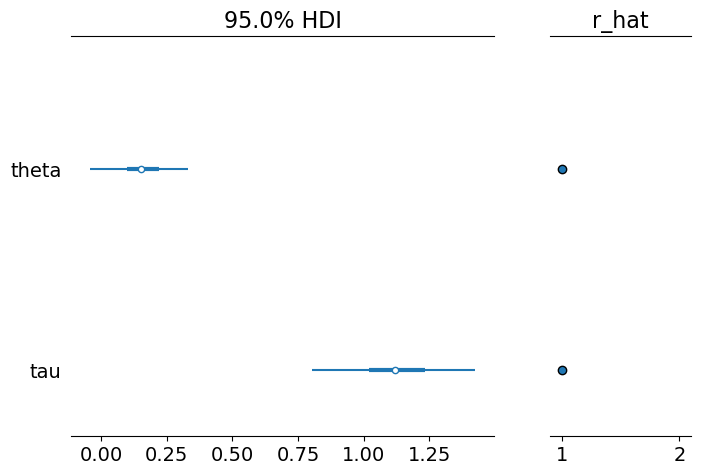

In [24]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=True, hdi_prob=0.95, r_hat=True);


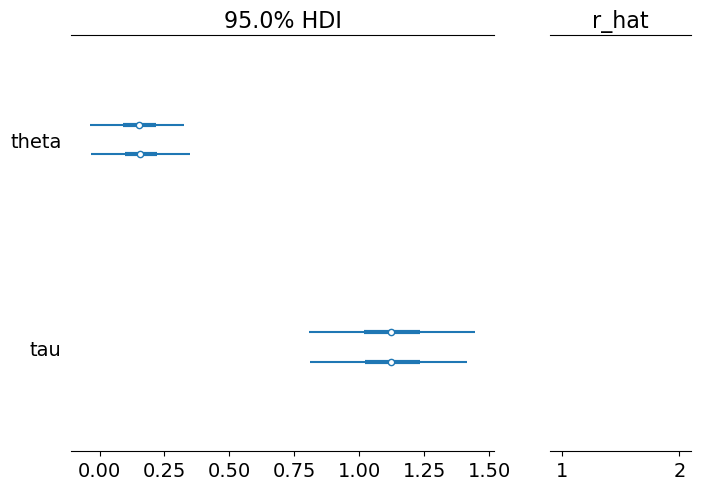

In [25]:
az.plot_forest(idata, var_names=["theta", "tau"], 
               combined=False, hdi_prob=0.95, r_hat=True);


## Part B: Posterior inference and diagnostics<br><sub>with `az.summary`</sub>

In [26]:
az.summary(idata, round_to=5)#2)
## ess: effective sample size.

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

In [27]:
theta.ravel().shape ## ravel() is used to flatten multi-dimensional arrays into one-dimensional arrays. 

(2000,)

### `mean` and `sd`

In [28]:
round_to=5
theta.ravel().mean().round(round_to), tau.ravel().mean().round(round_to)

(0.1559, 1.12676)

In [30]:
print(theta.ravel().std().round(round_to), tau.ravel().std().round(round_to))
theta.ravel().std(ddof=1).round(round_to), tau.ravel().std(ddof=1).round(round_to)

0.09399 0.16137


(0.09401, 0.16141)

### `hdi_3%` and `hdi_97%`

In [31]:
az.summary(idata, round_to=5)#2)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

In [32]:
np.quantile(theta,[0.05,0.95]).round(round_to)

array([0.00114, 0.31422])

In [33]:
np.quantile(theta,[0.025,0.975]).round(round_to)

array([-0.03126,  0.34397])

In [57]:
np.quantile(theta,[0.0265,0.967]).round(round_to)

array([-0.0287 ,  0.32743])

In [59]:
# hdi_3% and hdi_97% is something like
# move interval up or down until the smallest interval is found
np.quantile(theta,[0.02,0.96]).round(round_to)

array([-0.04009,  0.32163])

In [58]:
# so trying to get a bit closer for tau it's someting like
np.quantile(tau,[0.022,0.9622]).round(round_to)

array([0.81936, 1.41615])

### To consider `mcse_mean` and `mcse_sd`...

- [...moments of moments and first order Taylor series approximation](https://mc-stan.org/posterior/reference/mcse_sd.html)

In [60]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

In [61]:
az.summary(idata, round_to=5)['sd']['theta']/\
az.summary(idata, round_to=5)['ess_bulk']['theta']**0.5 ## mcse_mean for theta

0.002019219603258745

In [62]:
az.summary(idata, round_to=5)['sd']['tau']/\
(az.summary(idata, round_to=5)['ess_bulk']['tau']+0)**0.5 ## mcse_mean for tau

0.00490628205293743

In [63]:
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']


7.536692117807336e-08

In [64]:
# this estimates y which is the variance
((theta.ravel()-theta.ravel().mean())**2).mean()
theta.ravel().var()
# square root of this estimates standard deviation
# s = sqrt(y)

# this estimates variance of y above estimator
((theta.ravel()-theta.ravel().mean())**2).var()/\
az.summary(idata, round_to=5)['ess_bulk']['theta']

# by the delta method 
# https://stats.stackexchange.com/questions/491845/how-is-delta-method-used-here-in-approximating-the-square-root-of-a-normal-rando
# var(S) = (1/sqrt(E[Y]))**2 * Var(Y)

((1/theta.ravel().var())*\
 ((theta.ravel()-theta.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['theta'])**0.5

# So it's not quite right...but then again it's maybe not exactly
# https://mc-stan.org/posterior/reference/mcse_sd.html
# "Compute the Monte Carlo standard error for the 
#  standard deviation (SD) of a single variable 
#  without assuming normality using moments of moments 
#  and first order Taylor series approximation 
#  (Kenney and Keeping, 1951, p. 141)."

0.002920822818262386

In [65]:
((1/tau.ravel().var())*\
 ((tau.ravel()-tau.ravel().mean())**2).var()/\
 az.summary(idata, round_to=15)['ess_bulk']['tau'])**0.5

0.007552447824397351

In [66]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

### We must first consider `bulk_tail` and `ess_tail`...

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


In [67]:
theta_in_tail = \
(theta<=np.quantile(theta.ravel(),0.05))#+\
(theta>=np.quantile(theta.ravel(),0.95))
print(theta_in_tail.sum()/(2*m))
theta_in_tail

0.05


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

1478.3529785722699

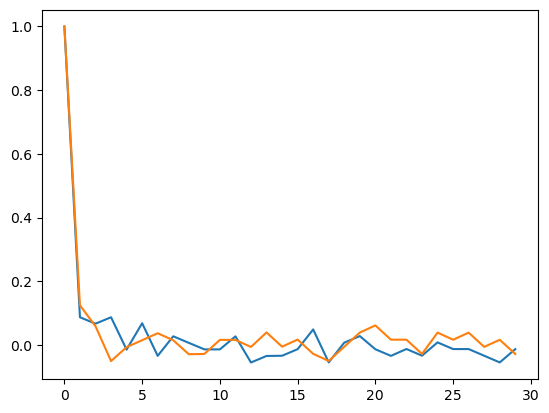

In [68]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta_in_tail[c,:-t_plus_k], 
                    theta_in_tail[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [69]:
autocorrelations[:,:10]

array([[ 1.        ,  0.08709691,  0.06675882,  0.08699634, -0.01450456,
         0.06828853, -0.03415989,  0.02722494,  0.00668959, -0.01384814],
       [ 1.        ,  0.12460568,  0.05890351, -0.05057956, -0.00685654,
         0.01498152,  0.03682171,  0.01488095, -0.0289548 , -0.02822794]])

In [70]:
tau_in_tail = \
(tau<=np.quantile(tau.ravel(),0.05))+\
(tau>=np.quantile(tau.ravel(),0.95))
print(tau_in_tail.sum()/(2*m))
tau_in_tail

0.1


array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False, False]])

1018.9522080464371

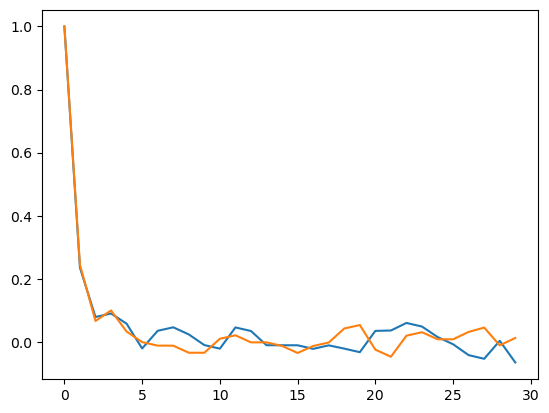

In [71]:
m = 1000
K = 30
autocorrelations = np.ones((2,m-1))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau_in_tail[c,:-t_plus_k], 
                    tau_in_tail[c,t_plus_k:])[0,1]
        
for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[8,6]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())

In [72]:
autocorrelations[:,:20]

array([[ 1.00000000e+00,  2.35410172e-01,  7.90383784e-02,
         9.01006743e-02,  5.78696666e-02, -2.07544192e-02,
         3.52237458e-02,  4.63358416e-02,  2.37877091e-02,
        -9.98777008e-03, -2.13243547e-02,  4.59085234e-02,
         3.45752236e-02, -1.04422604e-02, -1.05565235e-02,
        -1.06710445e-02, -2.20167779e-02, -1.09008638e-02,
        -2.12126329e-02, -3.26142791e-02],
       [ 1.00000000e+00,  2.44360400e-01,  6.64587973e-02,
         9.96989967e-02,  3.29017857e-02, -5.58659218e-04,
        -1.17897092e-02, -1.19036954e-02, -3.42600897e-02,
        -3.43771044e-02,  1.00000000e-02,  2.10123735e-02,
        -1.35135135e-03, -1.46561443e-03, -1.27088036e-02,
        -3.50847458e-02, -1.29411765e-02, -1.92525481e-03,
         4.24943311e-02,  5.35187287e-02]])

In [73]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

#### Reminder 

- [bulk_tail](https://mc-stan.org/posterior/reference/ess_bulk.html)
- [ess_tail](https://mc-stan.org/posterior/reference/ess_tail.html)

#### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$


2279.7159191869277

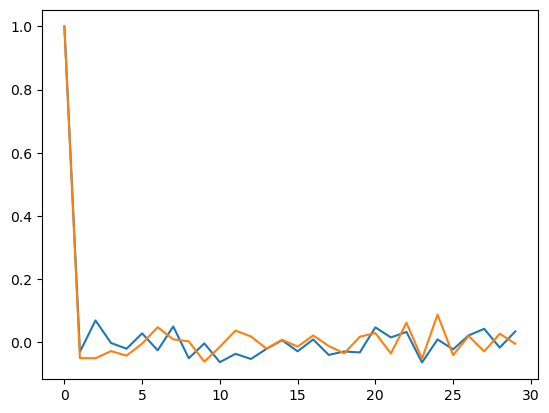

In [74]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(theta[c,:-t_plus_k], 
                    theta[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[3,4]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [75]:
autocorrelations[:,:10]

array([[ 1.        , -0.03059414,  0.06881944, -0.00267463, -0.02086612,
         0.02786411, -0.02583779,  0.04963   , -0.05097506, -0.0039743 ],
       [ 1.        , -0.0504697 , -0.05110254, -0.02825945, -0.04281395,
        -0.00458677,  0.04734809,  0.00886336,  0.00267714, -0.06190602]])

1084.0699754529765

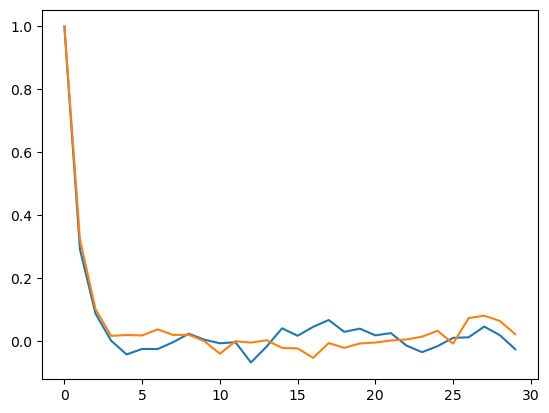

In [76]:
m = 1000
K = 30
autocorrelations = np.ones((2,int(m/2)))
for c in range(C):
    for t_plus_k in range(1, int(m/2)):
        autocorrelations[c,t_plus_k] = \
        np.corrcoef(tau[c,:-t_plus_k], 
                    tau[c,t_plus_k:])[0,1]

for c in range(C):
    plt.plot(autocorrelations[c,:K], label="Chain "+str(c)) 

# effective sample size
approximation_stops=[5,7]
approximation_stops,
m / (1 + 2*autocorrelations[0,1:approximation_stops[0]].sum())+\
m / (1 + 2*autocorrelations[1,1:approximation_stops[1]].sum())


In [77]:
autocorrelations[:,:10]

array([[ 1.00000000e+00,  2.92479432e-01,  8.82996225e-02,
         2.41742445e-03, -4.15044690e-02, -2.41574356e-02,
        -2.44336389e-02, -2.55614022e-03,  2.43096950e-02,
         5.20380053e-03],
       [ 1.00000000e+00,  3.23691506e-01,  1.02552015e-01,
         1.72718461e-02,  2.01658220e-02,  1.87012679e-02,
         3.79664504e-02,  2.01724415e-02,  2.08851279e-02,
         8.11438000e-04]])

In [78]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

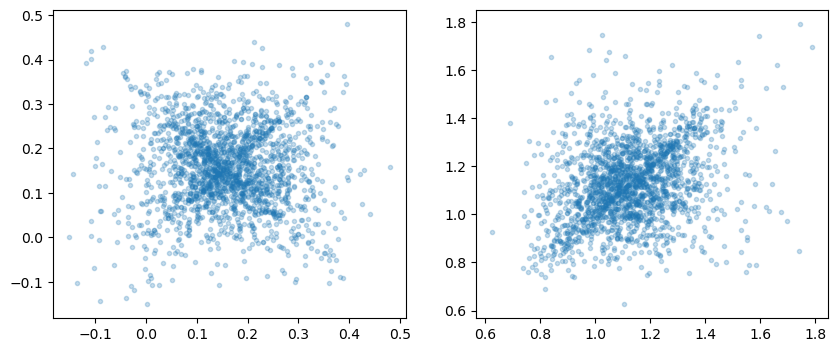

In [79]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(theta.ravel()[:-1], theta.ravel()[1:], '.', alpha=0.25)
ax[1].plot(tau.ravel()[:-1], tau.ravel()[1:], '.', alpha=0.25);

## Part C: R-hat and "energy"

A lack of insufficient "mixing" (agreement) between chains is diagnosed by comparing within and between chain variability. This is done by **checking if the split-$\hat R$ statistic is greater than** $\mathbf{1.05}$. is deemed sufficient when . This is suggestive (but not proof) that the the **Markov chains** have converged to their **stationary distributions**.

> Thus far above we have avoided the notion of "split" chains. Split chains must be considered to ensure that a "drifting chain" does not accidentally pass the $\hat R$ check. Thus the split-$\hat R$ statistic.


$\Large \text{Split-}\hat R  = \sqrt{\frac{\frac{N-1}{N}W +  \overbrace{\frac{1}{M-1}\sum_{m=1}^M (\overline{\theta^{(m,\cdot)}} - \overline{\theta^{(\cdot,\cdot)}})^2}^{\text{between chain variance}} }{\underbrace{\frac{1}{M}\sum_{m=1}^M \frac{1}{N-1}\sum_{n=1}^N (\theta^{(m,n)} - \overline{\theta^{(m,\cdot)}})^2}_{\text{$W$: within chain variance}}} } $ 

In [80]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    1.12676  0.16141  0.81498  1.41000    0.00486  0.00344  1082.32042   
theta  0.15590  0.09401 -0.02867  0.32742    0.00202  0.00152  2167.60926   

         ess_tail    r_hat  
tau    1163.87216  1.00251  
theta  1302.54960  0.99978

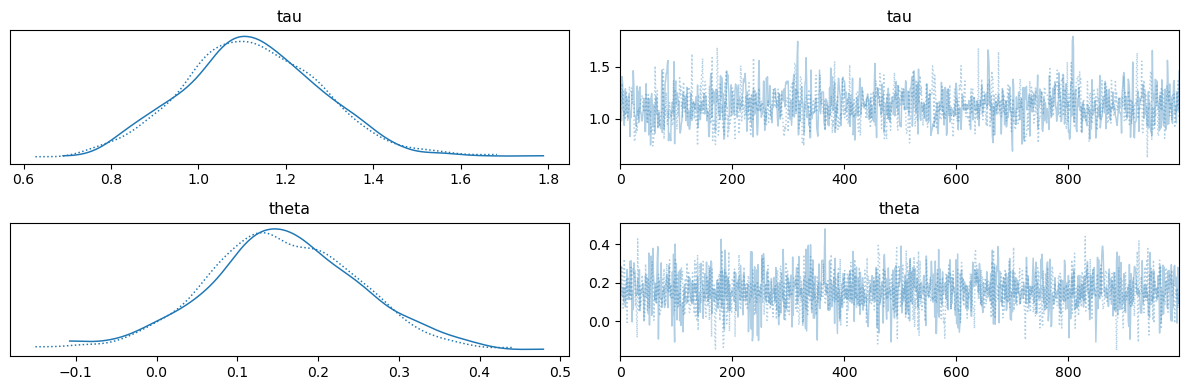

In [81]:
az.plot_trace(idata)
plt.tight_layout()

### Energy

Another diagnostic that sometimes applies is based on the so-called [energy](https://discourse.mc-stan.org/t/help-understanding-bfmi-interpreting-bfmi-1/28554). The exact meaning of "energy" will be discussed next class but for now suffice it to say that when the "Energy transition" fails to dominate the "Marginal energy" the sampler is experiencing a computational bottleneck.


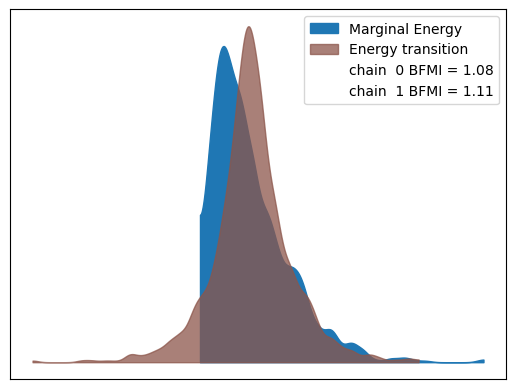

In [82]:
az.plot_energy(idata);

## Part D: Samplers


In [ ]:
pymc.sample?

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.13  0.16    0.83     1.41        0.0      0.0   2022.11   2329.65   
theta  0.16  0.09   -0.03     0.33        0.0      0.0   2156.78   2498.25   

       r_hat  
tau      1.0  
theta    1.0

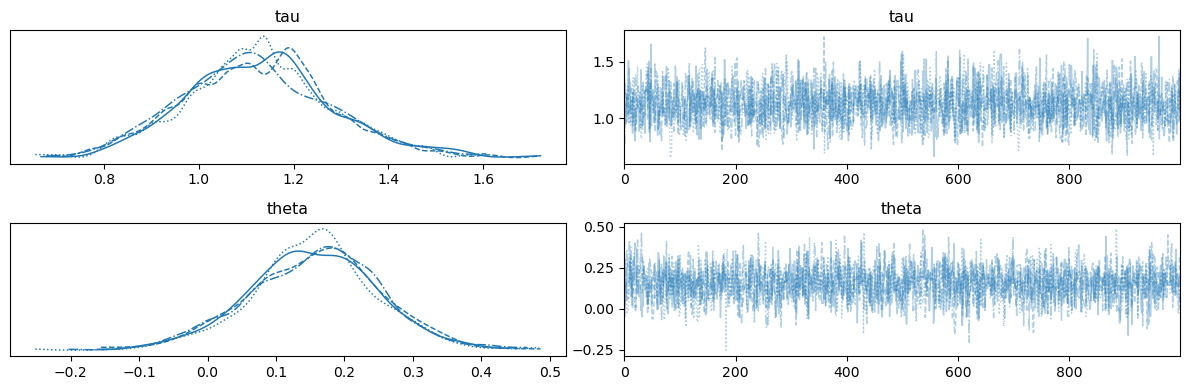

In [83]:
with conjugate_normal_gamma:
    HMC = pymc.HamiltonianMC()
    idata_HMC = pymc.sample(chains=4, step=HMC)
    
display(az.summary(idata_HMC, round_to=2))
az.plot_trace(idata_HMC)
plt.tight_layout()    

In [84]:
# theta rejection rates
(idata_HMC.posterior.theta.values[:,:-1]==idata_HMC.posterior.theta.values[:,1:]).mean(axis=1)

array([0.28228228, 0.32432432, 0.31831832, 0.27227227])

In [85]:
# tau rejection rates
(idata_HMC.posterior.tau.values[:,:-1]==idata_HMC.posterior.tau.values[:,1:]).mean(axis=1)

array([0.28228228, 0.32432432, 0.31831832, 0.27227227])

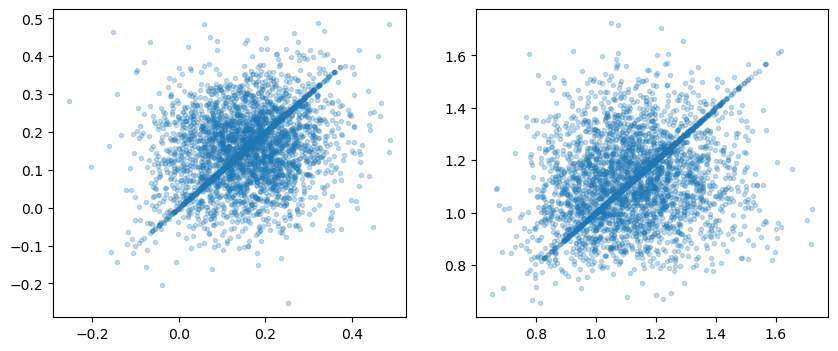

In [86]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_HMC.posterior.theta.values.ravel()[:-1], 
           idata_HMC.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_HMC.posterior.tau.values.ravel()[:-1], 
           idata_HMC.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.13  0.16    0.84     1.42        0.0      0.0   3186.91   2617.14   
theta  0.15  0.09   -0.02     0.33        0.0      0.0   3367.16   2793.23   

       r_hat  
tau      1.0  
theta    1.0

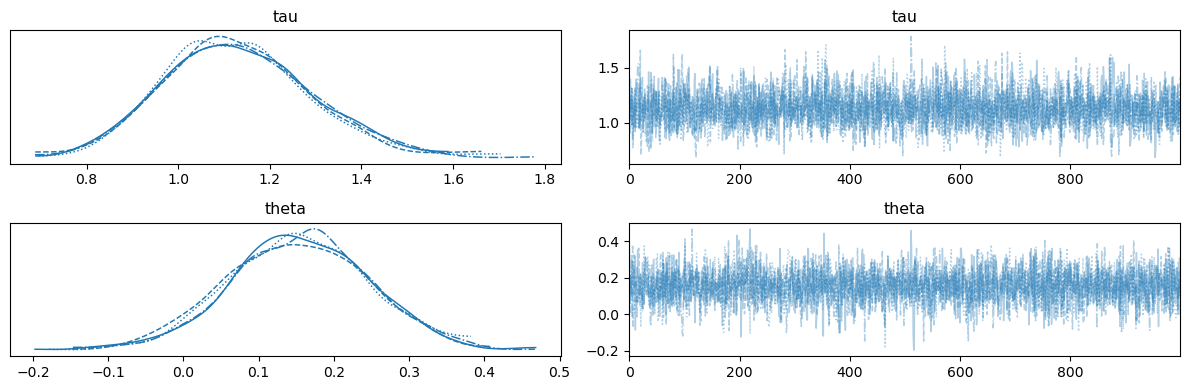

In [87]:
with conjugate_normal_gamma:
    idata = pymc.sample(chains=4, target_accept=0.9)
    
display(az.summary(idata, round_to=2))
az.plot_trace(idata)
plt.tight_layout()    

In [88]:
import pandas as pd
display(pd.DataFrame(idata.sample_stats.acceptance_rate))
# rejection rates
1-idata.sample_stats.acceptance_rate.values.mean(axis=1)

0         1         2         3         4         5         6    \
0  0.987943  0.857389  0.989613  1.000000  0.992772  1.000000  0.625934   
1  0.971616  1.000000  0.990998  0.974703  0.922156  0.930035  0.992761   
2  1.000000  0.974667  0.885840  0.998905  1.000000  0.799264  0.946068   
3  1.000000  0.975307  1.000000  0.989791  0.841693  0.930941  0.781153   

        7         8         9    ...       990       991       992       993  \
0  0.928745  1.000000  0.890310  ...  0.798367  1.000000  0.956784  0.751136   
1  0.965990  0.890602  0.903297  ...  0.954661  0.919267  1.000000  0.977478   
2  0.871662  1.000000  0.998645  ...  0.797741  0.977789  1.000000  0.991043   
3  1.000000  0.949379  0.815504  ...  0.965866  1.000000  0.997508  0.918907   

        994       995       996       997       998       999  
0  0.591487  1.000000  0.815555  0.996694  0.985213  0.912646  
1  0.942278  0.781732  0.992448  0.893217  0.914737  0.848853  
2  0.714281  0.726764  1.000000  0.944388  0.999169  0.936862  
3  0.931977  0.786066  0.919278  0.976615  0.959508  0.861939  

[4 rows x 1000 columns]

array([0.09741551, 0.08059217, 0.09303929, 0.09327689])

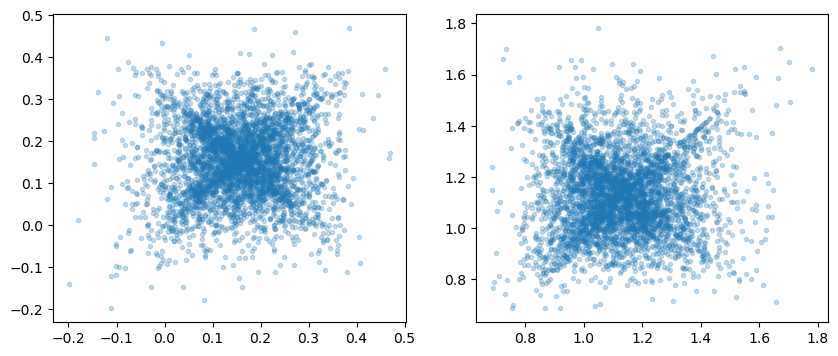

In [89]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata.posterior.theta.values.ravel()[:-1], 
           idata.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata.posterior.tau.values.ravel()[:-1], 
           idata.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [theta]
>Slice: [tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.13  0.16    0.84     1.42        0.0      0.0   3510.17   2915.13   
theta  0.15  0.09   -0.03     0.32        0.0      0.0   3964.63   2696.41   

       r_hat  
tau      1.0  
theta    1.0

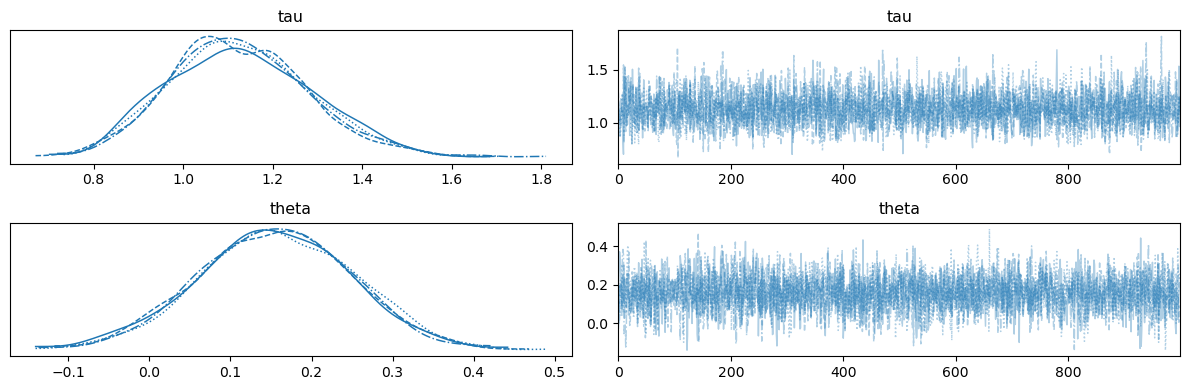

In [90]:
with conjugate_normal_gamma:
    sampler = pymc.Slice()
    idata_slice = pymc.sample(step=sampler)

display(az.summary(idata_slice, round_to=2))
az.plot_trace(idata_slice)
plt.tight_layout()    

In [91]:
# theta rejection rates
(idata_slice.posterior.theta.values[:,:-1]==idata_slice.posterior.theta.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

In [92]:
# tau rejection rates
(idata_slice.posterior.tau.values[:,:-1]==idata_slice.posterior.tau.values[:,1:]).mean(axis=1)

array([0., 0., 0., 0.])

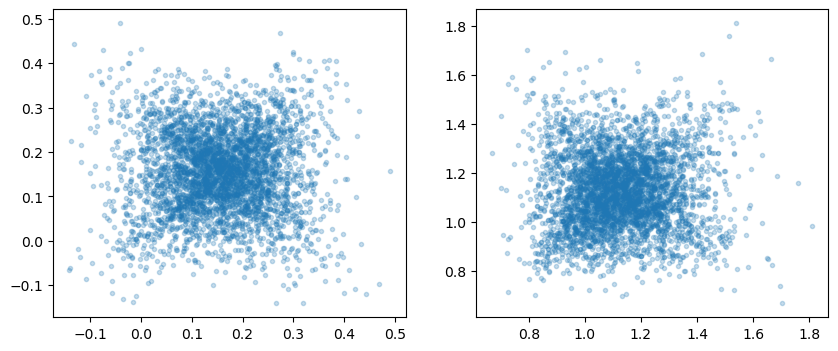

In [93]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_slice.posterior.theta.values.ravel()[:-1], 
           idata_slice.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_slice.posterior.tau.values.ravel()[:-1], 
           idata_slice.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.14  0.16    0.86     1.43       0.01     0.01    391.19    431.61   
theta  0.15  0.10   -0.03     0.34       0.01     0.00    319.49    217.72   

       r_hat  
tau     1.02  
theta   1.02

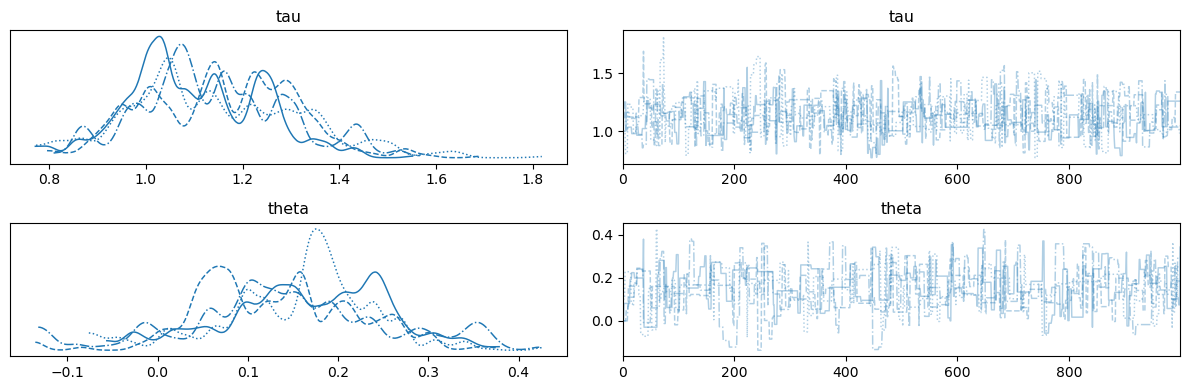

In [94]:
with conjugate_normal_gamma:
    MHv1 = pymc.Metropolis(S=np.ones(1), scaling=1, tune=False)
    idata_MHv1 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv1)

display(az.summary(idata_MHv1, round_to=2))
az.plot_trace(idata_MHv1)
plt.tight_layout()    

In [95]:
# theta rejection rates
(idata_MHv1.posterior.theta.values[:,:-1]==idata_MHv1.posterior.theta.values[:,1:]).mean(axis=1)

array([0.88288288, 0.88988989, 0.88188188, 0.86086086])

In [96]:
# tau rejection rates
(idata_MHv1.posterior.tau.values[:,:-1]==idata_MHv1.posterior.tau.values[:,1:]).mean(axis=1)

array([0.82682683, 0.83083083, 0.83783784, 0.82282282])

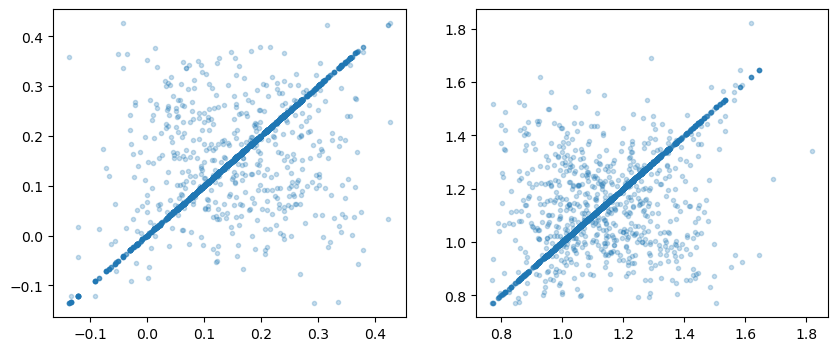

In [97]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv1.posterior.theta.values.ravel()[:-1], 
           idata_MHv1.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv1.posterior.tau.values.ravel()[:-1], 
           idata_MHv1.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [theta]
>Metropolis: [tau]


Sampling 4 chains for 0 tune and 1_000 draw iterations (0 + 4_000 draws total) took 1 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
tau    1.12  0.16    0.83     1.42       0.01     0.01    301.79    427.18   
theta  0.16  0.10   -0.02     0.33       0.00     0.00    439.60    506.65   

       r_hat  
tau     1.02  
theta   1.01

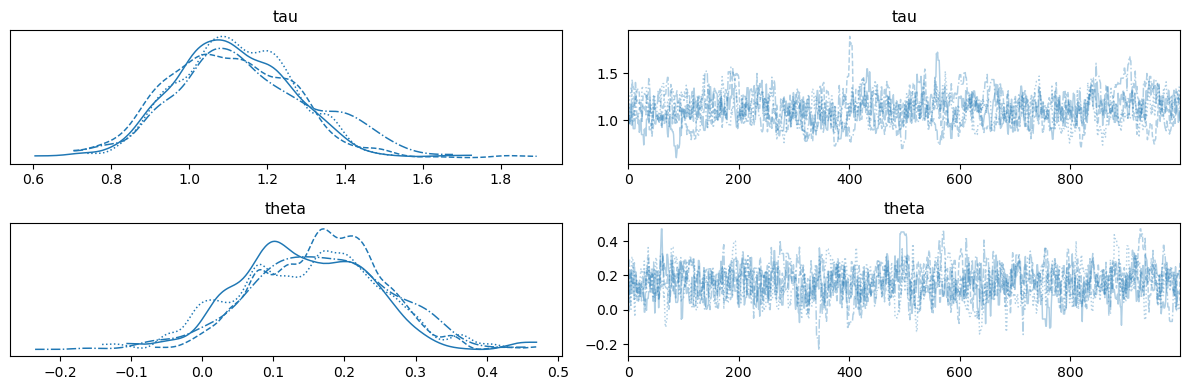

In [98]:
with conjugate_normal_gamma:
    MHv2 = pymc.Metropolis(S=np.ones(1), scaling=0.1, tune=False)
    idata_MHv2 = pymc.sample(draws=1000, tune=0, chains=4, step=MHv2)

display(az.summary(idata_MHv2, round_to=2))
az.plot_trace(idata_MHv2)
plt.tight_layout()    

In [ ]:
# theta rejection rates
(idata_MHv2.posterior.theta.values[:,:-1]==idata_MHv2.posterior.theta.values[:,1:]).mean(axis=1)

In [ ]:
# tau rejection rates
(idata_MHv2.posterior.tau.values[:,:-1]==idata_MHv2.posterior.tau.values[:,1:]).mean(axis=1)

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(idata_MHv2.posterior.theta.values.ravel()[:-1], 
           idata_MHv2.posterior.theta.values.ravel()[1:], '.', alpha=0.25)
ax[1].plot(idata_MHv2.posterior.tau.values.ravel()[:-1], 
           idata_MHv2.posterior.tau.values.ravel()[1:], '.', alpha=0.25);

## Week 5 Homework

---

### Q1: Questions about PyMC...

Complete this formatted markdown listing of the contents of "PyMC Example Gallery". *Include links and your favorite image (right click and "copy image address") from each page.*


#### Introductory

- [General Overview](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)
- [Simple Linear Regression](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/GLM_linear.html)
- [General API quickstart](https://www.pymc.io/projects/examples/en/latest/introductory/api_quickstart.html)

| | | |
|-|-|-|
|![](https://www.pymc.io/projects/docs/en/stable/_images/ac30f30b2297ec4f2bb798b4f28d2cbba2d0502dbaae4a5f78fdd5cccacda517.svg)|<img src="https://www.pymc.io/projects/docs/en/stable/_images/a8276d1222c43c061dbfff6fa3ff3af15b86038fd7d1e204c429ae3714ea1a20.png"  width="500"/>|![](https://www.pymc.io/projects/examples/en/latest/_images/434538d8660bf2399ebf9df11cbd2b7cec62d8abafc588da625315074b628118.png)|

#### Library Fundamentals

- [Distribution Dimensionality](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/dimensionality.html#dimensionality)
- [PyMC and PyTensor](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_pytensor.html#pymc-pytensor)
- [Using Data Containers](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)

| | | |
|-|-|-|
|1|2|3|


#### Etc.

- 1. [Splines](https://www.pymc.io/projects/examples/en/latest/howto/spline.html)
- 2. [GLM-ordinal-features](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-ordinal-features.html)
- 3. [Out-of-Sample-Prediction](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-out-of-sample-predictions.html)
- 4. [Binomial regession](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-binomial-regression.html)
- 5. [GLM: Negative Binomial Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-negative-binomial-regression.html)
- 6. [GLM-missing-values-in-covariates](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-missing-values-in-covariates.html)
- 7. [GLM: Poisson Regression](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-poisson-regression.html)
- 8. [GLM: Model Selection](https://www.pymc.io/projects/examples/en/latest/generalized_linear_models/GLM-model-selection.html)
- 9. [Hierarchical Partial Pooling](https://www.pymc.io/projects/examples/en/latest/case_studies/hierarchical_partial_pooling.html)
- 10. [Factor analysis](https://www.pymc.io/projects/examples/en/latest/case_studies/factor_analysis.html)
- 11. [Reliability Statistics and Predictive Calibration](https://www.pymc.io/projects/examples/en/latest/case_studies/reliability_and_calibrated_prediction.html)
- 12. [Interrupted time series analysis](https://www.pymc.io/projects/examples/en/latest/causal_inference/interrupted_time_series.html)



| | | |
|-|-|-|
|1|2|3|
|4|5|6|
|7|8|9|
|10|11|12|


| | | |
|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/996c551a7532a891f3783b61285697fbff9a999c593f528abe1c2448ed2a6455.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/0f445f9b032e3e7693732b2051d3340186c4db3eec9ea8a6d29b2b59b4512af7.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/300d0cf80648831ccb0009c099225a7540f30c1fc7e80e3cd24f2dcaf375f6bd.png) |


| | | |
|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/2af54aa3c6d0dcc893750608896f94dc41d623fee75756f05e3e97b629e9718a.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/15707fccc92da51bc592954d9b0db8e7507d02bb298a5060840b2681af815c9c.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/985e3771701853b6c582c314da571199130d76599e4bdfa48dea7f1285ab550f.svg) |


| | | |
|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/ecad18f81b29b2c6538f64e1933c8cf5c42c93fa3c979e06f6e70dca79b34f4f.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/ed7699a6e25a231bc26bf80eef6c6a66b58388a41e553907dfd9eb8b4d47dadc.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/ebc23400283c5ac276dcac1cb83402a474a679bf3963131b9f20349b2c052dea.svg) |


| | | |
|-|-|-|
| ![](https://www.pymc.io/projects/examples/en/latest/_images/d3902baec3a16548e994f270bd575d058f63b0919d3aad6bc4b5ab68e650e06d.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/1ddddc2ce12894e22ff1bc74b396959ffd6b767618149d1a97527c8ae26327b6.png) | ![](https://www.pymc.io/projects/examples/en/latest/_images/49d3e0b1e33ef95f1905ed0e648bc790fadb21183cf29156f75e742ff162e1b2.png) |


### Q2: Continue "Q2" of the previous weeks 3 and 4

1. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a normal distribution and your prior for $\tau$ is a gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

2. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a non normal distribution and your prior for $\tau$ is a non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*

3. *Use PyMC to provide Bayesian inference for the paramaters associated with a sample of normal data where your prior for theta is a yet another different again non normal distribution and your prior for $\tau$ is a yet another different again non-gamma distribution. Provide diagnostic assessments of the performance of your algorithm.*



In [1]:
import pymc
import arviz as az
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np

In [3]:
n = 100
true_theta, true_tau = 0, 1
data_generating_mechanism = stats.norm(loc=true_theta, scale=true_tau**(-0.5))
x = data_generating_mechanism.rvs(size=n)

In [4]:
# Part 1

with pymc.Model() as model:
    
    theta = pymc.Normal("theta", mu=0, sigma=1)

    tau = pymc.Gamma("tau", alpha=2, beta=1)
    
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)
       
    idata = pymc.sample(draws=2000, chains=2, tune=1000)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


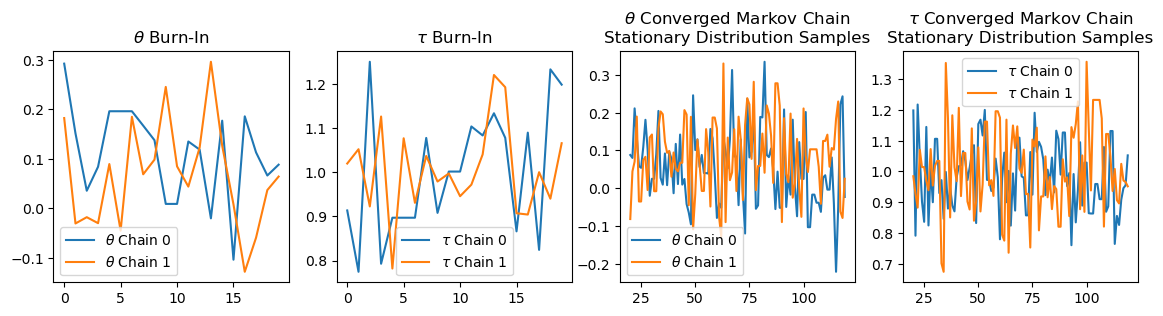

In [5]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

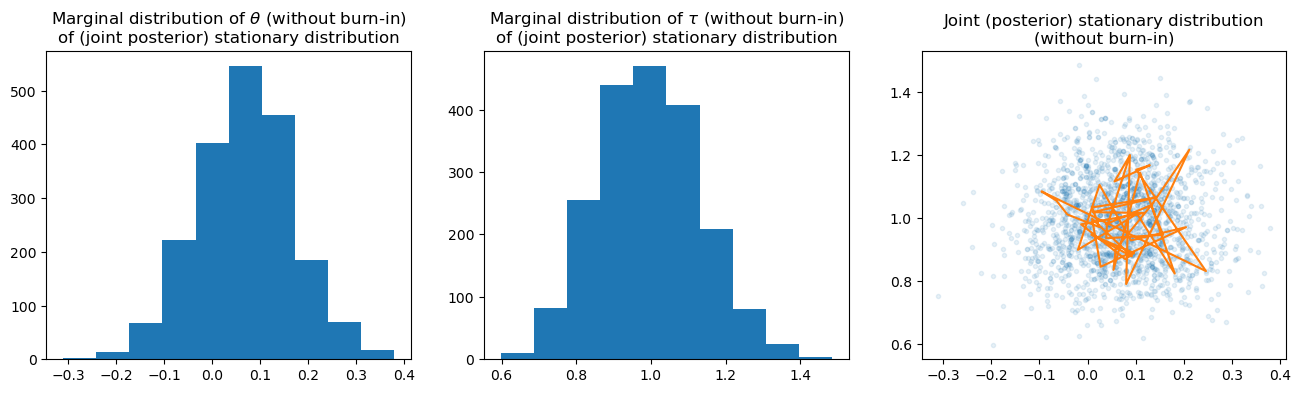

In [6]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

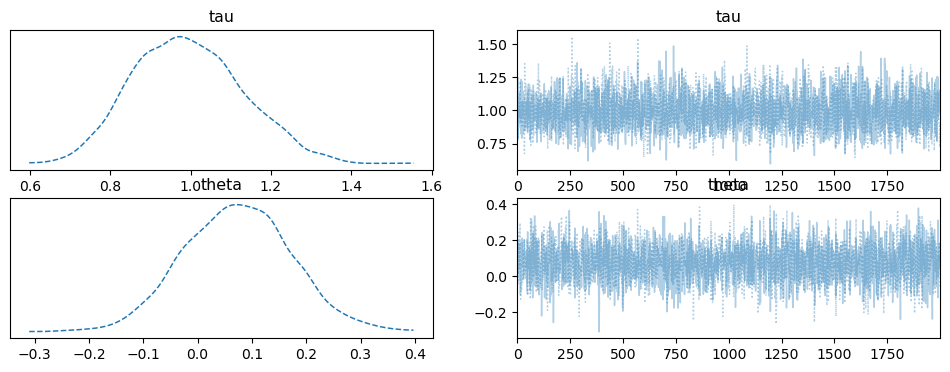

In [7]:
az.plot_trace(idata, combined=True);

Above plots shows the sampled distributions of $\theta$ and $\tau$. 

In [8]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.99504  0.13641  0.75548  1.25357    0.00237  0.00170  3341.60251   
theta  0.07274  0.09923 -0.10945  0.25843    0.00173  0.00144  3284.37801   

         ess_tail    r_hat  
tau    2590.81671  1.00116  
theta  2960.88503  1.00133

This summary table shows the approximate 95% HDIs for the estimated $\tau$ and $\theta$. From this, we can know the approximate intervals for the two values. 

Also, the table shows the effective sample size and r_hat, which show the effectiveness of samples. 

array([<Axes: title={'center': 'tau\n0'}>,
       <Axes: title={'center': 'tau\n1'}>,
       <Axes: title={'center': 'theta\n0'}>,
       <Axes: title={'center': 'theta\n1'}>], dtype=object)

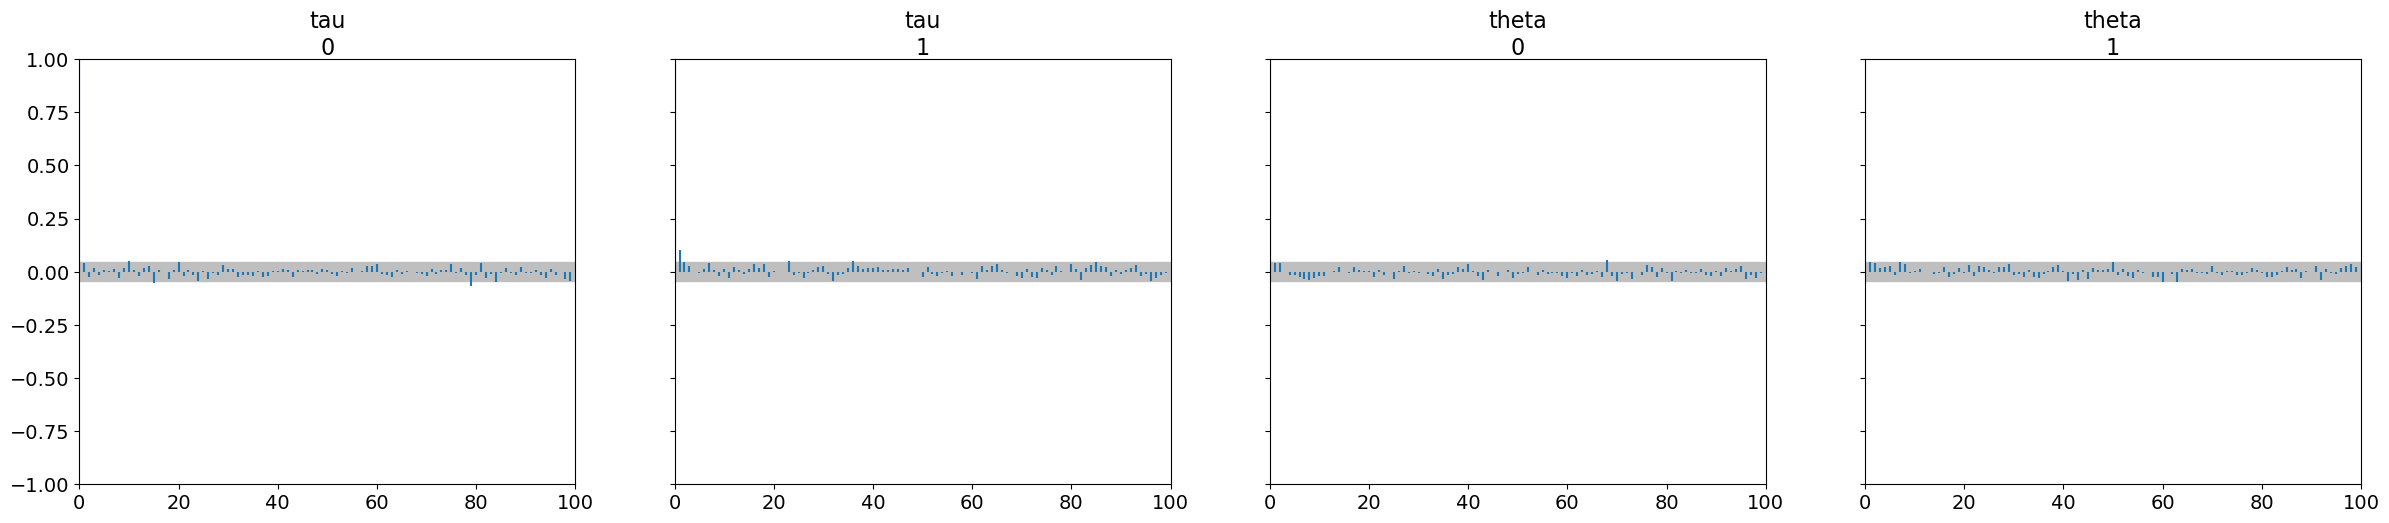

In [9]:
az.plot_autocorr(idata)

These plots shows the autocorrelations of $\tau$ and $\theta$ for each two chains. 

In [10]:
# Part 2

with pymc.Model() as model:
    
    theta = pymc.StudentT("theta", nu=3, mu=0, sigma=1)
    
    tau = pymc.InverseGamma("tau", alpha=2, beta=1)
    
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)
    
    idata = pymc.sample(draws=2000, chains=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


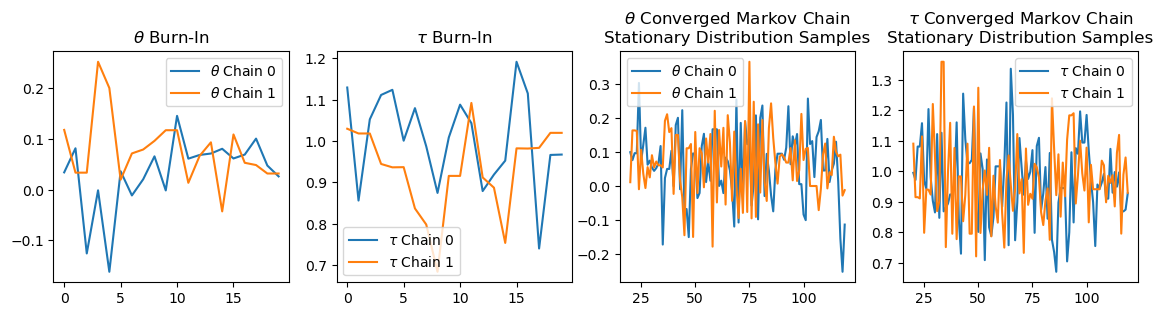

In [11]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

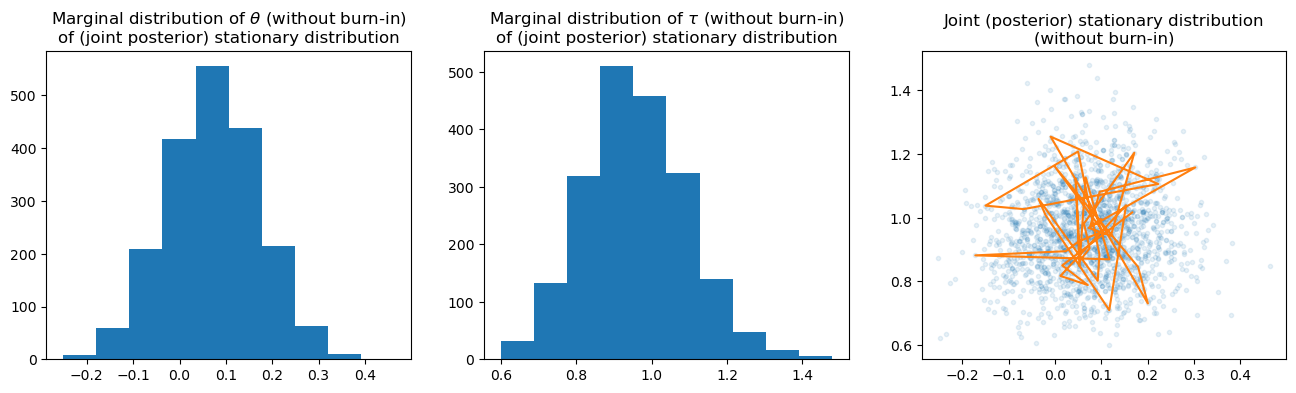

In [12]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

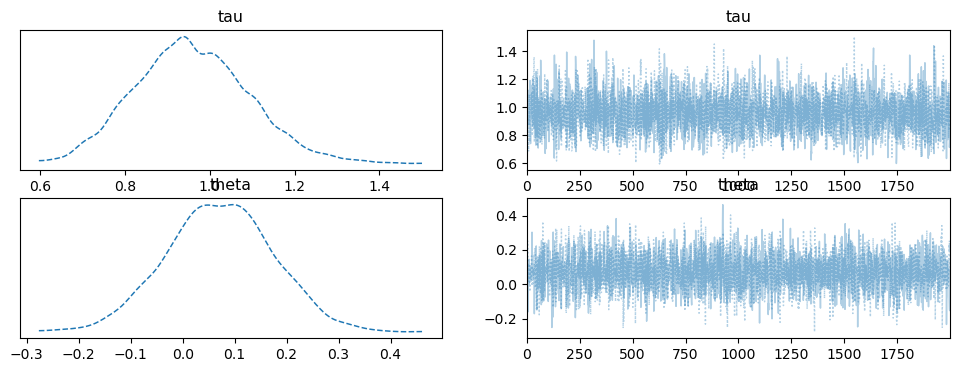

In [13]:
az.plot_trace(idata, combined=True);

In [14]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.95823  0.13557  0.69917  1.20161    0.00223   0.0016  3722.83928   
theta  0.07122  0.10245 -0.11472  0.26639    0.00163   0.0014  3939.18332   

         ess_tail    r_hat  
tau    2511.51670  0.99991  
theta  3003.93832  1.00042

array([<Axes: title={'center': 'tau\n0'}>,
       <Axes: title={'center': 'tau\n1'}>,
       <Axes: title={'center': 'theta\n0'}>,
       <Axes: title={'center': 'theta\n1'}>], dtype=object)

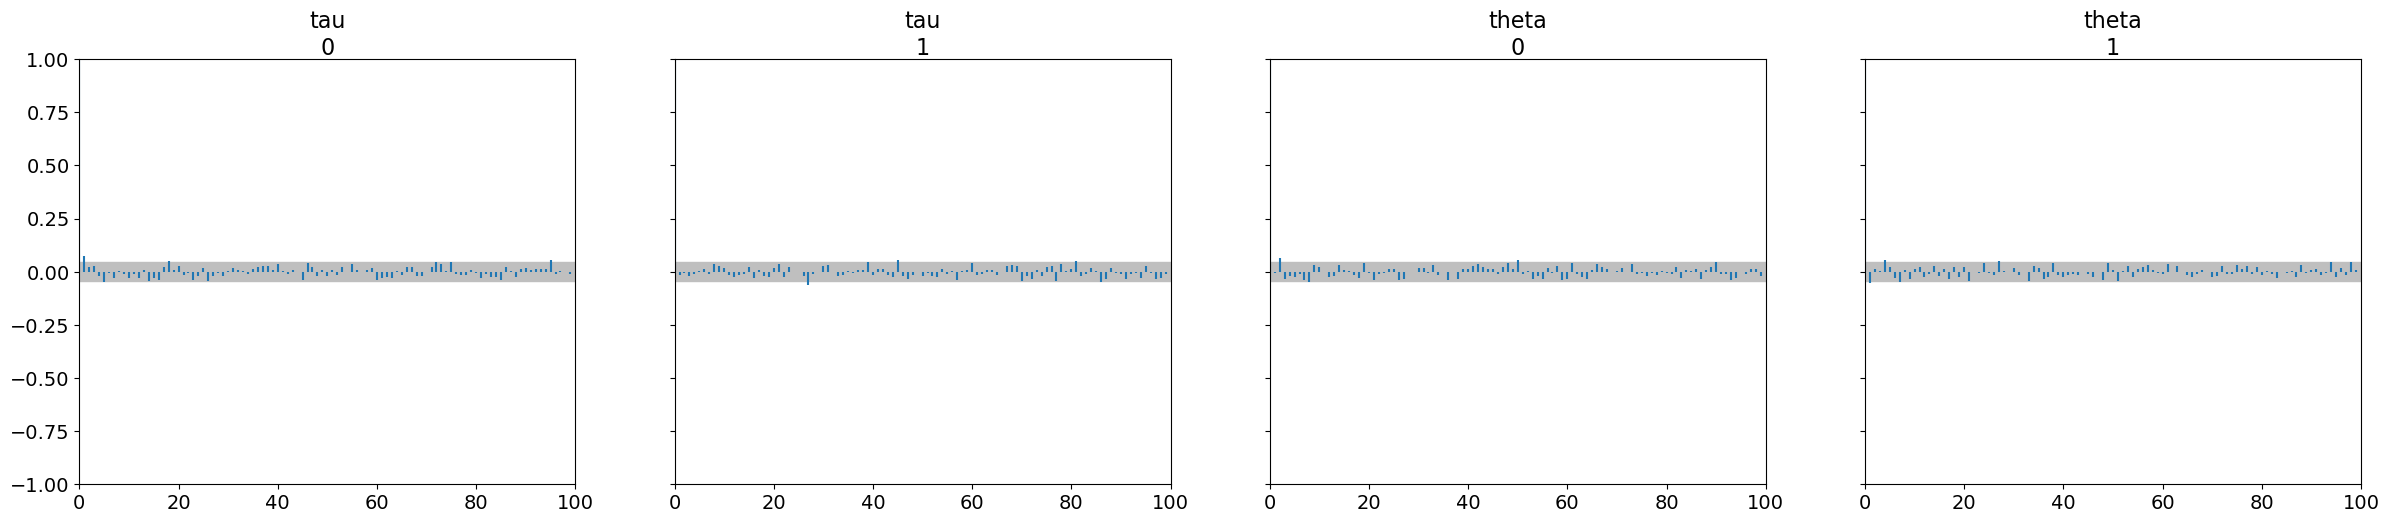

In [15]:
az.plot_autocorr(idata)

In [16]:
# Part 3
with pymc.Model() as model:
    # Cauchy prior for theta (another non-normal)
    theta = pymc.Cauchy("theta", alpha=0, beta=1)
   
    # Log-Normal prior for tau (another non-gamma)
    tau = pymc.Lognormal("tau", mu=0, sigma=1)
       
    # Likelihood
    x_obs = pymc.Normal("x_obs", mu=theta, tau=tau, observed=x)
       
    # Sample
    idata = pymc.sample(draws=2000, chains=2, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta, tau]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


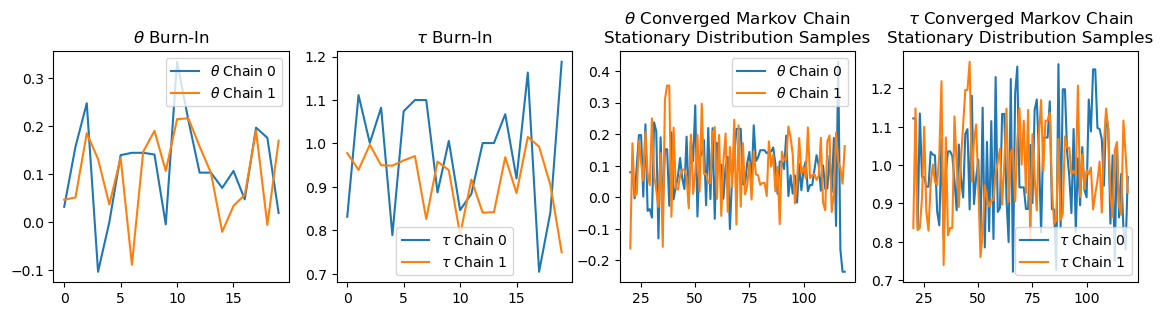

In [17]:
theta = idata.posterior['theta'].values#.shape
tau = idata.posterior['tau'].values#.shape

fig,ax = plt.subplots(1, 4, figsize=(14,3));ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")

# pymc.sample(draws=1000, chains=2, tune=100)
# used 100 samples per chain to "tune" and these were
# automatically discarded so `burn` is likely not needed
burn = 20
demo = 120
C = 2
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();  

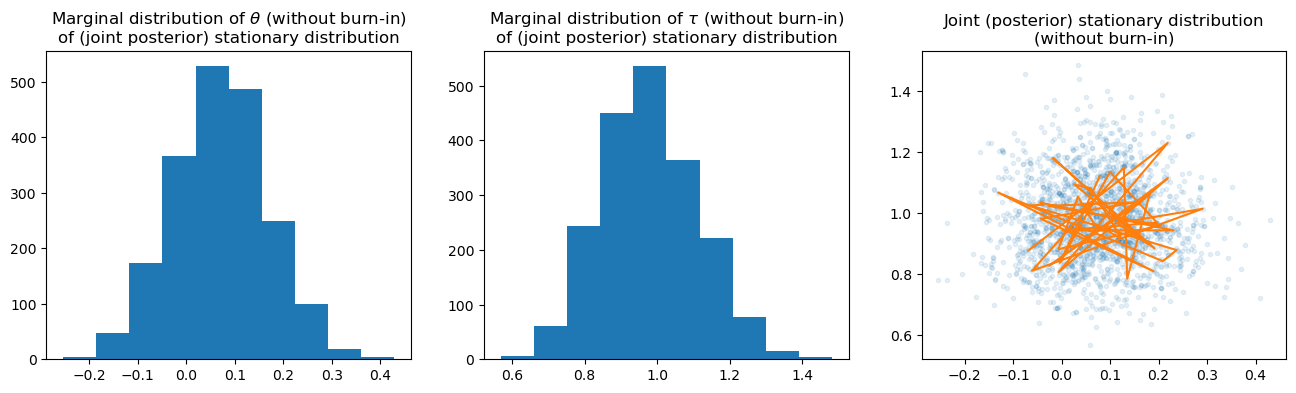

In [18]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distribution")
ax[2].set_title("Joint (posterior) stationary distribution\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

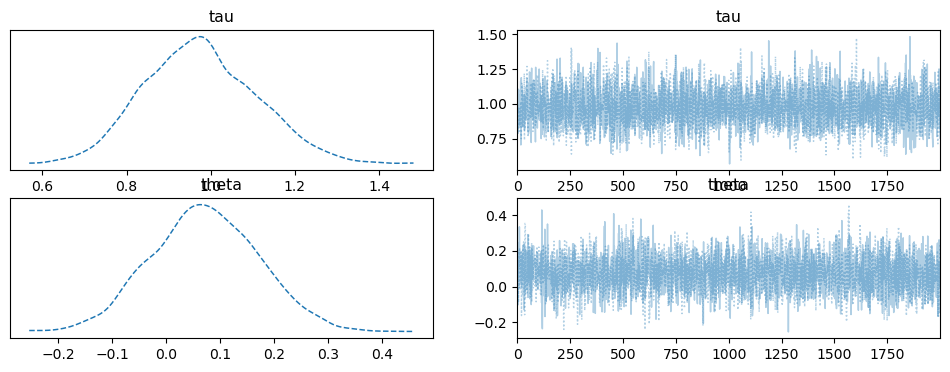

In [19]:
az.plot_trace(idata, combined=True);

In [20]:
az.summary(idata, round_to=5)

mean       sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd    ess_bulk  \
tau    0.97520  0.13361  0.73908  1.23118    0.00215  0.00152  3854.60027   
theta  0.07175  0.09941 -0.10116  0.27006    0.00156  0.00134  4082.60721   

         ess_tail    r_hat  
tau    2763.28411  1.00025  
theta  3118.99495  1.00004

array([<Axes: title={'center': 'tau\n0'}>,
       <Axes: title={'center': 'tau\n1'}>,
       <Axes: title={'center': 'theta\n0'}>,
       <Axes: title={'center': 'theta\n1'}>], dtype=object)

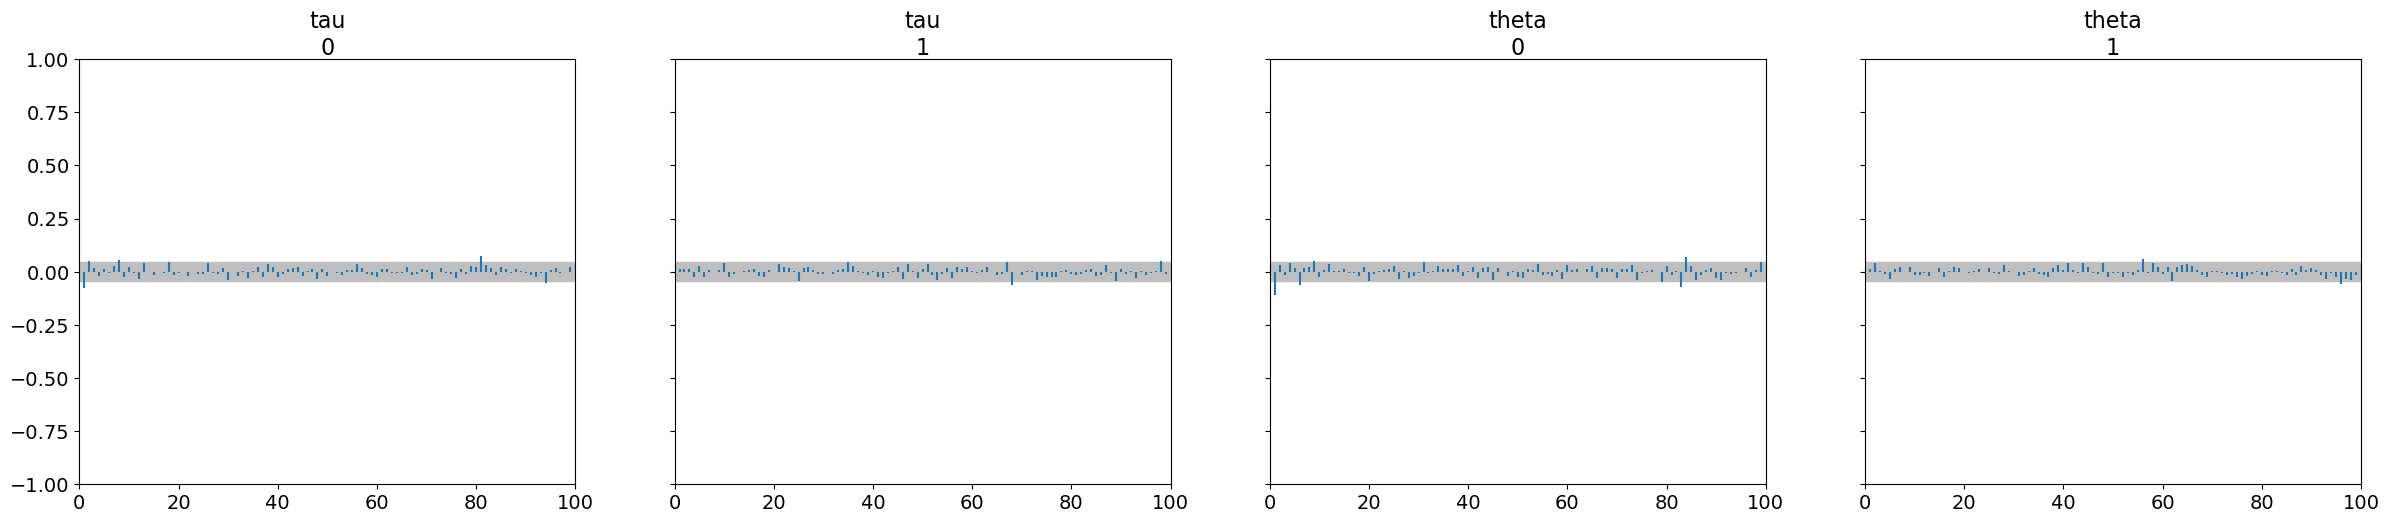

In [21]:
az.plot_autocorr(idata)

### Q3: Slice Sampling

*First explain how the Markov algorithm of slice sampling as given below works. Then explain the steps by which slice sampling could be used in place of a Metropolis-Hasting step in a Metropolis within Gibbs algorithm where the full conditionals are only known up to a normalizing constant. In your explanation clarify what the curve that we're sampling beneath is, and what the initial value and steps are to create the draw for Gibbs sampling.*

In [5]:
def slice_f_at_y(f, x, y, x_grid=np.linspace(0,1,51)):
    
    # find interval of grid points where f(x_grid) > y 
    # then extend the enterval so endpoints f(a)<y and f(b)<y 
    x_grid_delta = x_grid[1]-x_grid[0] # delta = 1/50, meaning width
    a,b = x_grid[f(x_grid)>y][[0,-1]]+[-x_grid_delta,x_grid_delta]
    # a,b = x_grid[0,-1]  # make the interval all of x_grid
    
    x_ = a + stats.uniform().rvs()*(b-a)    
    if f(x_)>y:
        return x_,1  # in 1 try if f(x_)>y and "x_ is under f" 
    elif x_ < x:  # or if "x_ was above f on the left side of the interval" 
        x_l,x_r = x_,b
    else:
        x_l,x_r = a,x_  # or if "x_ was above f on the right side of the interval"
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = 2)  # try again with a reduced interval

def slice_f_at_y_(f, x, y, x_l=0, x_r=1, tot=1):
    
    x_ = x_l + stats.uniform().rvs()*(x_r-x_l)
    
    if f(x_)>y:
        return x_,tot
    elif x_ < x:
        x_l = x_
    else:
        x_r = x_
    return slice_f_at_y_(f, x, y, x_l, x_r, tot = tot+1)


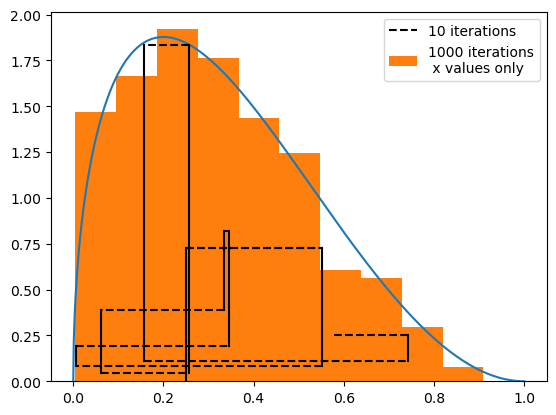

In [6]:
x_grid = np.linspace(0,1,1000)
f = lambda x: stats.beta(1.5,3).pdf(x)
plt.plot(x_grid, f(x_grid))
    
m = 1000
x = np.zeros([m+1,3])
x[:2,0] = 0.25

plot_trace = 10
for t in range(1,m):
    
    x[t,1] = stats.uniform().rvs()*f(x[t,0])
    if t < plot_trace:
        plt.plot([x[t,0]]*2, [x[t-1,1],x[t,1]], 'k')
    
    x[t+1,0],x[t+1,2] = slice_f_at_y(f, x[t,0], x[t,1])
    if t < plot_trace:
        if t==1:
            plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--', label=str(plot_trace)+ " iterations")
        plt.plot([x[t,0], x[t+1,0]], [x[t,1]]*2, 'k--')
    
plt.hist(x[:,0], density=True, label=str(m)+" iterations\n x values only")
plt.legend();

1. Instead of directly sampling from the target density f(x), slice sampling samples y uniformly between 0 and f(x), defining a "slice" beneath the curve. Then, it finds an interval where f(x)>y and samples a new x within this range. If the new x is valid, it is accepted; otherwise, the interval is shrunk, and the process repeats. This ensures that the samples follow the target distribution without requiring a proposal distribution like in Metropolis-Hastings.

2. In a Metropolis-within-Gibbs setting, slice sampling can replace the Metropolis-Hastings step. The conditional density function serves as the curve we sample beneath. Starting from the current value of x, we first sample y uniformly below the conditional density. Next, we determine an interval where the density is above y and draw a new x from this range. If the new x satisfies the condition, it is accepted; otherwise, we shrink the interval and retry.

3. The curve we are sampling beneath in slice sampling is the unnormalized full conditional density function. The initial value for each step is the determined x value from the previous step. 